<a href="https://colab.research.google.com/github/amandusossian/Epidemic-simulation/blob/main/SIR_resultgather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#@title Kör detta block för att göra programmet redo för körning { form-width: "300px" }

# Imports
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from __future__ import print_function
import copy

np.seterr(invalid='ignore')
!mkdir saved_results

def setupNN():
    """ This function initializes the nueral network and returns the model-object that represents it.
    
        Returns:
        model: The neural network model.
    """ 
    
    model = Sequential()  # Define the NN model 
    model.add(Flatten())
    model.add(Dense(50,  activation='relu'))  # Add Layers (Shape kanske inte behövs här?) 
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # softmax ensures number between 0-1.
    model.compile(loss = 'mean_squared_error', optimizer='adam', metrics='accuracy')
    
    return model

def trainNN(model, CR_tensor, test_results, test_capacity):
    """ This function trains the neural network based on tests made in the 20 first timesteps. The samples are weighted to account for the fact that it maight be 
    an uneven distribution between trainingdata on sick and healthy agents. 

    Args:
        model : The neual network model.
        CR_tensor : A tensor containing information about the R-matrices and contacts for the agents tested before t = 20. Contains this information for the 10 latest timesteps.
        test_results : A list containing the results of the outcomes of the previously made tests.  
        test_capacity : Number of avalilable tests per timestep  

    Returns:
        model : The trained neual network model.
    """

    reshaped_CR_tensor = np.reshape(CR_tensor, (test_capacity*20,50))
    reshaped_test_results = np.reshape(test_results, test_capacity*20)
    quota = len(np.where(reshaped_test_results == 1)[0])/(test_capacity*20)
    sample_weights = np.ones(test_capacity*20)*quota
    sample_weights[reshaped_test_results == 1] = (1 - quota)
    model.fit(reshaped_CR_tensor, reshaped_test_results, sample_weight = sample_weights, epochs=100, verbose = 0) #vilken batch size?  #Input för NN, lista, där varje plats är matrix som i artikeln
    model.evaluate(reshaped_CR_tensor, reshaped_test_results, verbose=2)
    
    return model

def make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor):
    """ The neural network makes a prediction for each of agent how likely it thinks the agent is sick, based on their information in the CR_tensor. 
    It returns these probabilities as a list.

    Args:
        t : Current timestep.
        n : Number of agents.
        model : The neural network model. 
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps. 
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts for each agent in the last 10 timesteps. Contains this information for the 10 latest timesteps. 
        n_tensor : A tensor containing information about the R-matrices and the contact-matrices for every agent. Contains this information for the 10 latest timesteps.

    Returns:
        resultNN : A list of probabilities from how probable the neural network thinks each agent is sick. 
        n_tensor : A tensor containing information about the R-matrices and the contact-matrices for every agent. Contains this information for the 10 latest timesteps. 
    """

    slicing_list = [(t-j)%10 for j in range(10) ]
    for i in range(n):
        n_tensor[i] = np.array([R_4[(slicing_list, i)], R_8[(slicing_list, i)], R_16[(slicing_list, i)], 
        total_contact_i[(slicing_list, i)], contact_q[(slicing_list, i)]])

    resultNN = model.predict(np.reshape(n_tensor, (n, 50)))
    
    return resultNN, n_tensor
    
 

def deployNN(resultNN):
    """ Given the predictions from the neural network, this function returns two lists of agents. 
    One list of agents that are to be isolated immediately, and a list with the agents that should be tested. 

    Args:
        resultNN : A list of probabilities from how probable the neural network thinks each agent is sick. 

    Returns:
        most_plausibly_sick_agents : The agents that the neural network thinks should be isolated. 
        maybe_sick_agents : The agents that the neural network thinks should be tested. 
    """
    most_plausibly_sick_agents  = np.where(resultNN>0.995)[0]

    maybe_sick_agents = np.where((0.5<resultNN) & (resultNN<=0.995))[0]
    rising_probability_indexes = np.argsort(maybe_sick_agents)
    maybe_sick_agents = rising_probability_indexes[::-1]
    
    return most_plausibly_sick_agents, maybe_sick_agents

def gen_information_to_peter(t, tested_agents, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor):
    """ Generates the CR-tensor, which is used by the neural network for training. 

    Args:
        t : Current timestep.
        tested_agents :  List of indices of the tested agents.
        test_capacity : How many tests that are available per timestep. 
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps. 
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts for each agent in the last 10 timesteps. Contains this information for the 10 latest timesteps. 
        CR_tensor : A tensor containing information about the R-matrices and contacts for the agents tested before t = 20. Contains this information for the 10 latest timesteps.

    Returns:
        CR_tensor : A tensor containing information about the R-matrices and contacts for the agents tested before t = 20. Contains this information for the 10 latest timesteps.
    """

 
    #Tensor for prediction regarding all agents
    slicing_list = [(t-j)%10 for j in range(10) ]
    
    for i in range(test_capacity):
        k = tested_agents[i]
        CR_tensor[t][i] = np.array([R_4[(slicing_list, k)] , R_8[(slicing_list, k)], R_16[(slicing_list, k)], 
        total_contact_i[(slicing_list, k)], contact_q[(slicing_list, k)]])
    
    return CR_tensor
 
def peter_test(peter_test_list, test_capacity, isolated, S, false_prob):
    """ The neural networks testing function. From the agents in peter_test_list, test agents until test_capacity is reached, or no more agents remain. 

    Args:
        peter_test_list : The agents to be tested.
        test_capacity : Number of tests available per timestep.
        isolated : A list of information regarding which agents are isolated
        S : List of states of the agents. 
        false_prob : The probability of a test returning the incorrect value. 

    Returns:
        isolated : Updated isolated list. 
    """
    results_from_peters_test = np.zeros(test_capacity)
    i = 0
    test_range = test_capacity
    
    if len(peter_test_list) < test_capacity:
        test_range = len(peter_test_list)

    for agent in peter_test_list[:test_range]:
        if S[agent] == 1:
            results_from_peters_test[i] = 1
        i +=1

    if false_prob>0:
        false_negatives = np.where((results_from_peters_test == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((results_from_peters_test == 0)&(np.random.random(test_capacity)<false_prob))[0]
        results_from_peters_test[false_negatives] = 0
        results_from_peters_test[false_positives] = 1

    for j in range(min(test_range, test_capacity)):
        if results_from_peters_test[j] == 1:
            isolated[int(peter_test_list[j])] = 1
   
    return isolated
 
def peter_isolate(S, peter_isolate_list, isolated):
    """ The neural networks isolationfunction. Isolates the agents in peter_isolate_list.

    Args:
        S : List of states of the agents.
        peter_isolate_list : List of agents that the neural network wants to isolate.   
        isolated : A list of information regarding which agents are isolated

    Returns:
        isolated : Updated isolation list.
        new_total_isolations : Number of new isolations. 
        new_false_isolations : How many of the newly isolated agents were wrongfully isolated. 
    """
    
    new_total_isolations = 0
    new_false_isolations = 0
    for agent in peter_isolate_list:
        if S[agent] != 3:
            if isolated[agent] == 0:
                new_total_isolations +=1
                if S[agent] != 1:
                    new_false_isolations +=1
            isolated[agent] = 1
        
    return isolated, new_total_isolations, new_false_isolations

def __init__(n, l, initial_infected):
    """ Initializes many of the tensors used in the simulation and returns them.

    Args:
        n : Number of agents.
        l : The size of the society(ies).
        initial_infected : How many agents start of as infected.

    Returns:
        Initialized versions of  x, y, x_init, y_init, S, isolated, temperatures, nx, ny
    """

    x = np.floor(np.random.rand(n) * l)  # x coordinates
    y = np.floor(np.random.rand(n) * l)  # y coordinates
    S = np.zeros(n)  # status array, 0: Susceptiple, 1: Infected, 2: recovered, 3: Dead
    isolated = np.zeros(n)  # Isolation array, 0: not isolated, 1: Is currently in isolation
    temperatures = np.zeros(n, dtype='float16')  # temperature array
    S[0:initial_infected] = 1  # Infect random agents
    nx = x  # updated x
    ny = y  # updated y
    x_init = x
    y_init = y
    
    return x, y, x_init, y_init, S, isolated, temperatures, nx, ny

def init_cr(n, test_capacity):
    """ Initializes the contact-matrices and the R-matrices. 

    Args:
        n : Number of agents.
        test_capacity : Number of tests available per timestep.

    Returns:
        The initialized tensors contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor
    """
    # Contact matrices
    contact_tot = np.zeros((50, n), dtype='int16')
    contact_i = np.zeros((50, n), dtype='int16')
    total_contact_tot = np.zeros((10, n), dtype='int16')
    total_contact_i = np.zeros((10, n), dtype='int16')
    contact_q = np.zeros((50, n), dtype='float16')

    # R matrices
    R_4 = np.zeros((10, n))
    R_8 = np.zeros((10, n))
    R_16 = np.zeros((10, n))
    
    CR_tensor = np.zeros((20, test_capacity,5,10))

    return contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor

def gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q ):
    """ Generates the contact-matrices in the case of multiple societies. The contact-matrices measure the number of infected agents the agent has 
        been in contact with and the total number of agents the agent has been in contact with. 

    Args:
        t : Current timestep.
        n : Number of agents.
        S : List of states of the agents.
        isolated : A list of information regarding which agents are isolated
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        contact_i : How many sick agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        contact_tot : How many agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        total_contact_tot : The total number of contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts for each agent in the last 10 timesteps. Contains this information for the 10 latest timesteps.

    Returns:
        contact_i : How many sick agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        contact_tot : How many agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        total_contact_tot : The total number of contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts for each agent in the last 10 timesteps. Contains this information for the 10 latest timesteps.
    """
    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list
    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16): 
    """ Generates the R matrices in the case of multiple societies. The R matrices measure the 
    total number of infected agents within a certain radius.

    Args:
        t : Current timestep.
        n : Number of agents.
        S : List of states of the agents.
        isolated : List of information regarding which agents are isolated
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps.

    Returns:
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps.
    """
    
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
 
        list_of_16_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared)
        list_of_8_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared)
        list_of_4_hits = np.where(np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared)
 
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    
    return R_4, R_8, R_16


def gen_contact_trace(t, n, S, isolated, x, y, contact_trace):
    """ Generates the new addition to the contact tracing tensor, that contains infromation about which agents that have been at the same positions at a specific timestep.

    Args:
        t : Current timestep.
        n : Number of agents.
        S : List of the states of the agents.
        isolated: List of information regarding which agents are isolated.
        x : The x-positions of the agents.
        y : The y-postions of the agents.
        contact_trace : A tensor with information about which agents that have been in contact in the 10 latest timesteps.
        cships : The cizenships of the agents. 

    Returns:
        contact_trace: Updated tensor with information about which agents that have been in contact in the 10 latest timesteps
    """
    new_contacts = np.zeros((n,n), dtype = np.int8)

    for i in range(n):
        hits = np.where((S!=3)&(isolated != 1)&(x[i] == x)&(y[i] == y))[0]
        new_contacts[i][hits] = 1
    

    contact_trace[t%10] = new_contacts
    
    return contact_trace

def generate_new_positions(n, x, y, x_init, y_init, isolated, S, D):
    """ Generates new positions for the agents. Returns the new coordinates for the agents

    Args:
        n : Number of agents.
        x : The x-positions of the agents.
        y : The y-postions of the agents.  
        x_init : The starting x-positions of the agents. 
        y_init : The starting y-positions of the agents. 
        isolated : List of information regarding which agents are isolated.
        S : List of the states of the agents.
        D : The probability of movement for the agents.

    Returns:
        nx: New x-positions for the agents.
        ny: New y-positions for the agents.  
    """
    
    nx = copy.deepcopy(x)
    ny = copy.deepcopy(y)

    k = 0.04 # Determines the radius of movement of the agents from their startingposition
    for agent in range(n):
        prob_x = [
            max(0,1/3 +k*(x[agent]-x_init[agent])),
            1/3,
            max(0, 1/3-k*(x[agent]-x_init[agent]))
        ]
        prob_x /= sum(prob_x)
        prob_y = [max(0, 1/3 +k*(y[agent]-y_init[agent])), 1/3, max(0, 1/3-k*(y[agent]-y_init[agent]))]
        prob_y /= sum(prob_y)
        dx = np.random.choice([-1, 0, 1], p=np.array(prob_x))
        dy = np.random.choice([-1, 0, 1], p=np.array(prob_y))
        nx[agent] += dx
        ny[agent] += dy
    
    for i in np.where(((isolated != 0) | (S == 3) | (np.random.random(n) > D)))[0]:
        nx[i] = x[i]
        ny[i] = y[i]
    
    return nx, ny

def update_states(n, isolated, S, x, y, B, My_list, G, R):
    """ Updates the states in the S array of every agent.

    Args:
        n : Number of agents.
        isolated: List of information regarding which agents are isolated.
        S : List of states of the agents.
        temperatures : List of temperatures of the agents.
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        B : The probability of an infected agent to infect a susceptible agent. 
        My_list : List of probabilities for the agents to die if infected.
        G : The probability of an infected agent to recover.
        R : The probability of a recovered agent to become susceptible again. 
        cships : The citizenships of the agents. 

    Returns:
        isolated: Updated list of information regarding which agents are isolated.
        S: Updated list of states of the agents.
        new_sick_count: How many agents were infected in this timestep.
    """
    new_sick_count = 0
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # loop over infecting agents
        new_sick = np.where((x == x[i]) & (y == y[i]) & (S == 0))[0]
        S[new_sick] = 1  # Susceptiples together with infecting agent becomes infected
        new_sick_count += len(new_sick)

    for i in np.where((S == 1) & (np.random.random(n) < My_list))[0]:
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.rand(n) < G))[0]
    wrong_isolated = np.where((S!= 1) & (isolated == 1))[0]

    S[np.where((S==2)&(np.random.random(n) < R))[0]] = 0
    
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    isolated[wrong_isolated] = 0
    
    return S, isolated, new_sick_count

def generate_temperatures(S,n):
    """ Gives the agents temperatures from a random distribution. If the agent is sick the temperature is normally
        distributed around 37.4 and if the agent is not sick 36.8 degrees. Dead agents get temperature 0.

    Args:
        S : List of states of the agents.
        n : Number of agents.

    Returns:
        temperatures : List containing the temperatures of the agents. 
    """

    temperatures = np.zeros(n)
    for i in np.where(S == 1)[0]:
        temperatures[i] = np.random.normal(37.4, 1.2)
 
    for i in np.where((S == 0) & (S==2))[0]:
        temperatures[i] = np.random.normal(36.8, 1.0)

    for i in np.where(S == 3)[0]:
        temperatures[i] = 0

    return temperatures


def initial_testing(false_prob, t, temperatures, test_capacity, S, isolated):
    """ During the first 20 timesteps, this function does tests on randomly selected individuals,
    with high temperatures, isolates sick agents,and returns information that can be sent to the 
    neural network to be used as trainingdata. 

    Args:
        false_prob : The probability of a test returning false value.
        t : Current timestep. 
        temperatures : List containing the temperatures of the agents. 
        test_capacity : How many tests that can be made per timestep.
        S :   List of states of the agents.
        isolated: List of information regarding which agents are isolated.

    Returns:
        testing_outcome: The outcome of the preformed tests. 
        to_be_tested: The agents that were tested
        isolated: Updated list of information regarding which agents are isolated.
    """
    double_sick_people = max(min(len(S), 2*len(np.where(S==1)[0])), test_capacity)
    test_priority = np.argsort(temperatures)
    test_priority = test_priority[-double_sick_people:-1]
    rand_selected = np.random.choice(range(0,double_sick_people-1),test_capacity, replace = False)
    to_be_tested = test_priority[rand_selected]
    testing_outcome = np.zeros(test_capacity)
    
    for agents in range(test_capacity):
        if (S[to_be_tested[agents]] == 1):
            testing_outcome[agents] = 1
            
    
            
    if false_prob>0:
        false_negatives = np.where((testing_outcome == 1)&(np.random.random(test_capacity)<false_prob))[0]
        false_positives = np.where((testing_outcome == 0)&(np.random.random(test_capacity)<false_prob))[0]
        testing_outcome[false_negatives] = 0
        testing_outcome[false_positives] = 1

    for i in np.where(testing_outcome == 1)[0]:
        isolated[to_be_tested[i]] = 1

    return testing_outcome, to_be_tested, isolated

def contact_traced_testing(t, n, contact_i, temperatures, test_capacity, isolated, S, contact_trace):
    """ A testing strategy that based on the contacthistory of sick agents isolates their previous contacts. 

    Args:
        t : Current timestep.
        n : Number of agents.
        contact_i : List of how many sick contacts an agent has had. Contains this information for the latest 10 timesteps. 
        temperatures : List of temperatures of the agents. 
        test_capacity : How many tests are allowed per timestep. 
        isolated: List of information regarding which agents are isolated.
        S : List of states of the agents.
        contact_trace : A tensor with information about which agents that have been in contact in the 10 latest timesteps.

    Returns:
        isolated: Updated list of information regarding which agents are isolated.
    """
    contacts_to_isolate = np.array([], dtype = 'int64')
    d_type = [('Clist', np.int16), ('Temp', np.float16)]
    test_priority = np.zeros((n,), dtype=d_type)
    test_priority['Clist'] = contact_i[t % 10]
    test_priority['Temp'] = temperatures
    test_priority = np.argsort(test_priority, order=('Temp', 'Clist')) # Undersök ordning på dessa för att minska pricksäkerheten? 
    i = 0
    tests_made = 0
    while tests_made < test_capacity and i < n - 1:  # can't use more tests than allowed, and can't test more agents than there are agents
        test_person = test_priority[-i - 1]
        if (isolated[test_person] != 1):  # Proceed if the selected agent is not already isolated
            tests_made += 1  # A test is counted
            if S[test_person] == 1:  # Isolate sick testsubjects
                isolated[test_person] = 1
                for j in range(10):
                    new_contacted = np.where(contact_trace[(t-j)%10][test_person] == 1)[0]
                    contacts_to_isolate = np.append(contacts_to_isolate, new_contacted)
        i += 1

    if not np.any(contacts_to_isolate):
        return isolated
            
    counted = np.bincount(contacts_to_isolate)
    ordered = np.argsort(counted)
    isolate_without_testing = min((n//4 - len(np.where(isolated == 1)[0])), len(ordered))
    for k in range(max(isolate_without_testing, 0)):
        isolated[ordered[-1-k]] = 1
    
    return isolated

def gen_My_list(n,My_base, My_old, prop_old):
    """ From a value of the probability of death, generate a list containg the deathrate of the agents individually. Also generat a list of indexes fo the agents that are old. 
    This is mainly a feature implemented and used when there are agegroups activated, then the old people will have a higher deathrate. 

    Args:
        n : Number of agents.
        My_base : The base deathrate.
        My_old : The deathrate of old people.
        prop_old : The proportion of the agents should be old. 

    Returns:
        My_list: A list of the deathrates for the agents. 
        old_people: A list containing the indexes of the old agents.
    """
    My_list = np.array([My_base for i in range(n)]) 
    age_sample = np.random.random(n)
    old_people = np.where(age_sample < prop_old)[0]
    My_list[old_people] = My_old

    return My_list, old_people

def change_My_list(n,My_base, My_old, old_people):
    """ Changes the deathrates if a mutation occurs. 

    Args:
        n : Number of agents. 
        My_base : The new base deathrate.
        My_old : The deathrate of old people. 
        old_people : A list containing the indexes of the old agents. 

    Returns:
        My_list: Updated list of deathrates of the agents. 
    """
    My_list = np.array([My_base for i in range(n)]) 
    if My_old >0:
        My_list[old_people] = My_old
    
    return My_list

def hotspot(n, hotspot_position, nx, ny):
    """Moves a random portion of agents to hotspot position(s).

    Args:
        n : number of agents
        hotspot_position : 2 dimensional array containing the x and y coordinates of each hotspot.
        nx : agents' x coordinates
        ny : agents' y coordinates

    Returns:
        nx: agents' x coordinates while some are visiting hotspot
        ny: agents' y coordinates while some are visiting hotspot
        agent_orginal_postion_x: copy of agents' x coordinates
        agent_orginal_postion_y: copy of agents' x coordinates
    """

    agent_indices = np.random.choice(range(0,n), n//20, replace = False)   
    hotspot_indices = np.random.choice(range(len(hotspot_position)), size=agent_indices.shape)
    
    agent_orginal_postion_x = copy.deepcopy(nx)
    agent_orginal_positon_y = copy.deepcopy(ny)

    nx[agent_indices] = hotspot_position[hotspot_indices, 0]
    ny[agent_indices] = hotspot_position[hotspot_indices, 1]

    return nx, ny, agent_orginal_postion_x, agent_orginal_positon_y

def swap_cships(n, t, old_travelers, travelrate, socs, cships, cships_start):
    """ In the case of multiple societies, some agents will travel to another society. 
    After 10 timesteps they will return to their original society

    Args:
        n : Number of agents.
        t : Current timestep.
        old_travelers : List of agents that are away from their original society. Contains this information for 10 timesteps. 
        travelrate : How many agents that are allowed to travel per timestep.
        socs : How many societies the simulation is divided into. 
        cships : Current citizenships of the agents.
        cships_start : Original citizenships of the agents. 

    Returns:
        cships: Updated list of citizenships. 
        old_travelers: Updated list of agents that are in a different society than their original.
    """
    # Revert people that have traveled previously to their old citizenships
    cships[old_travelers[(t-9)%10]] = cships_start[old_travelers[(t-9)%10]]
    new_travelers = np.random.choice(range(0,n),travelrate, replace = False)
    old_travelers[(t-9)%10] = new_travelers

    # set the new cships for the new travelers
    new_socs = np.random.randint(0,socs, len(new_travelers))
    cships[new_travelers] = new_socs 

    return cships, old_travelers   

def gen_contact_trace_M(t,n,S,isolated,x,y, contact_trace, cships):
    """ Generates the new addition to the contact tracing tensor, that contains infromation about which agents that have been at the same positions at a specific timestep.
    This function is active in the case of multiple societies. 

    Args:
        t : Current timestep.
        n : Number of agents.
        S : List of states of the agents.
        isolated: List of information regarding which agents are isolated.
        x : The x-postitions of the agents.
        y : The y-postions of the agents.
        contact_trace : Tensor with information about which agents that have been in contact in the 10 latest timesteps.
        cships : List of citizenships of the agents. 

    Returns:
        contact_trace: Updated tensor with information about which agents that have been in contact in the 10 latest timesteps
    """
    
    new_contacts = np.zeros((n,n))
    for i in range(n):
        hits = np.where((S!=3)&(isolated != 1)&(x[i] == x)&(y[i] == y)&(cships[i] == cships))[0]
        new_contacts[i][hits] = 1
    
    contact_trace[t%10] = new_contacts
    
    return contact_trace


def update_states_M(n, isolated, S, x, y, B, My_list, G, R, cships):
    """ Updates the states in the S array of every agent, in the case of multiple societies.

    Args:
        n : Number of agents.
        isolated: List of information regarding which agents are isolated.
        S : List of states of the agents.
        temperatures : List of temperatures of the agents.
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        B : The probability of an infected agent to infect a susceptible agent. 
        My_list : List of probabilities for the agents to die if infected.
        G : The probability of an infected agent to recover.
        R : The probability of a recovered agent to become susceptible again. 
        cships : List of citizenships of the agents. 

    Returns:
        isolated: Updated list of information regarding which agents are isolated.
        S: Updated list of states of the agents.
        new_sick_count: How many agents were infected in this timestep.
    """
    new_sick_count = 0
    for i in np.where((isolated != 1) & (S == 1) & (np.random.random(n) < B))[0]:  # Loop over infecting agents
        new_sick = np.where((x == x[i]) & (y == y[i]) & (S == 0) & (cships[i] == cships))[0]
        S[new_sick] = 1                                     # Susceptiples together with infecting agent becomes infected
        new_sick_count += len(new_sick)

    for i in np.where((S == 1) & (np.random.random(n) < My_list))[0]: # Death Loop
        S[i] = 3
    recovered_list = np.where((S == 1) & (np.random.random(n) < G))[0]
    wrong_isolated = np.where((S!= 1) & (isolated == 1))[0]

    S[np.where((S==2)&(np.random.random(n) < R))[0]] = 0
    
    S[recovered_list] = 2
    isolated[recovered_list] = 0
    isolated[wrong_isolated] = 0
    return S, isolated, new_sick_count

def gen_contacts_M(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q, cships):
    """ Generates the C matrices in the case of multiple societies. The C matrices measure the number of infected agents the agent has 
    been in contact with and the total number of agents the agent has been in contact with. This function is active in the case of multiple societies.

    Args:
        t : Current timestep.
        n : Number of agents.
        S : List of states of the agents.
        isolated : List of information regarding which agents are isolated
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        contact_i : List of how many sick agents that an agent has been in contact with. Contains this information for the 50 latest timesteps.
        contact_tot : List of how many agents an agent been in contact with. Contains this information for the 50 latest timesteps.
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        total_contact_tot : The total number of contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts in the last 10 timesteps. Contains this information for the 10 latest timesteps.
        cships : Citizenships of the agents.

    Returns:
        contact_i : How many sick agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        contact_tot : How many agents has an agent been in contact with. Contains this information for the 50 latest timesteps.
        total_contact_i : The total number of sick contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        total_contact_tot : The total number of contacts for an agent in the latest 10 timesteps from the current one. Contains this information for the 10 latest timesteps.
        contact_q : The quota between the number of sick contacts divided by the total number of contacts in the last 10 timesteps. Contains this information for the 10 latest timesteps.
    """
    contact_list = np.zeros(n)
    sick_contact_list = np.zeros(n)
    coord_list = np.array([2**x[i] * 3**y[i] for i in range(n)])
    sick_free_agents = np.where((S == 1) & (isolated != 1))[0]
    non_dead_free_agents = np.where((S != 3) & (isolated != 1))[0]
 
    for infected in sick_free_agents :
        infected_agent = infected
        for other_agent in non_dead_free_agents:
            if (coord_list[infected_agent] == coord_list[other_agent]) & (infected_agent != other_agent) & (cships[infected_agent] == cships[other_agent]):
                sick_contact_list[other_agent] += 1
           
    for i in range(n):
        for hits in np.where((x[i] == x) & (y[i] == y) & (isolated != 1))[0]:
            contact_list[i] += 1
 
    contact_i[t % 50] = sick_contact_list
    contact_tot[t % 50] = contact_list

    total_contact_i[t%10] = np.sum(contact_i, 0)
    total_contact_tot[t%10] = np.sum(contact_tot, 0)
 
    contact_q[t % 10] =  np.nan_to_num(np.divide(np.sum(contact_i, 0),np.sum(contact_tot, 0)))
    
    return contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q 

def gen_R_M(t, n, S, isolated, x, y, R_4, R_8, R_16, cships):  
    """ Generates the R matrices in the case of multiple societies. The R matrices measure the 
    total number of infected agents within a certain radius. This function is active in the case of multiple societies.

    Args:
        t : Current time.
        n : Number of agents.
        S : List of states of the agents.
        isolated : List of information regarding which agents are isolated
        x : The x-positions of the agents.
        y : The y-postions of the agents. 
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps.
        cships : Citizenships of the agents.

    Returns:
        R_4 : How many agents within a radius of 4 are sick. Contains this information for the 10 latest timesteps.
        R_8 : How many agents within a radius of 8 are sick. Contains this information for the 10 latest timesteps.
        R_16 : How many agents within a radius of 16 are sick. Contains this information for the 10 latest timesteps.
    """
    temp_r16 = np.zeros(n)
    temp_r8 = np.zeros(n)
    temp_r4 = np.zeros(n)
    r16_squared = 256
    r8_squared = 64
    r4_squared = 16
   
    sick_list = np.where((S==1)&(isolated !=1))[0]
    xy_array = np.array([[x[i],y[i]] for i in range(n)])
 
    for sickos in sick_list:
        sick_coords = np.array([x[sickos], y[sickos]])
        list_of_16_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r16_squared) & (cships == cships[sickos]))
        list_of_8_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r8_squared) & (cships == cships[sickos]))
        list_of_4_hits = np.where((np.sum((xy_array-sick_coords)**2 , axis = 1)<=r4_squared) & (cships == cships[sickos]))
        temp_r16[list_of_16_hits] +=1
        temp_r8[list_of_8_hits] +=1
        temp_r4[list_of_4_hits] +=1
   
    # It should not count itself as a person in its vacinity, so remove 1 from the sick indexes
    temp_r16[sick_list] -= 1
    temp_r8[sick_list]  -= 1
    temp_r4[sick_list]  -= 1
 
    R_16[t%10] = temp_r16
    R_8[t%10] = temp_r8
    R_4[t%10] = temp_r4
    
    return R_4, R_8, R_16

def run_sir(input_list, start_model, max_time):
    """ This is the main function that runs the simulation.

    Args:
        input_list : List of parameters for the simulation.
        start_model : The starting model of the neural network.
        max_time : How long the simulation runs for.

    Returns:
        Lists of histories: How many agents where in the different states at the different timesteps
        total_isolations: How many agents the neural network isolated
        total_false_isolations: How many isolations made by the neural network that was innacurate
        total_sick_count: How many people that ever got sick

    """
    
    # [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    #  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    #  lockdown_start_time, lockdown_duration, proportion_of_old_people, mutation_start_time,
    #  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    #  new_loss_of_immunity_prob, neural_network_activated]
    # Parameters of the simulation
    n = int(input_list[0])                  # Number of agents
    l = 100                                 # Lattice size
    initial_infected = int(input_list[1])   # Initial infected agents   
    test_capacity = int(input_list[2])      # Testcapacity per timestep
    false_prob = int(input_list[3])
    B = input_list[4]                       # Infectionrate
    G = input_list[5]                       # Recoveryrate
    My_base = input_list[6]                 # Deathrate
    My_old = input_list[7]                  # Deathrate old people
    R = input_list[8]

    D_noll = 0.8                            # Probability of movement
    D_reduced = 0.1
    D = D_noll
    start_lock = int(input_list[9])         # Starttime of potential lockdown
    lockdown_duration = input_list[10]
    prop_old = input_list[11]
    
    # Mutation
    mutation_start = input_list[12]
    new_B = input_list[13]
    new_G = input_list[14]
    new_R = input_list[15]
    new_My_base = input_list[16]
    new_My_old = input_list[17]

    # Neural network
    nn_activated = input_list[18]
    if nn_activated: 
        model = start_model

    #initiate the lists
    x, y, x_init, y_init,  S, isolated, temperatures, nx, ny = __init__(n,l,initial_infected)
    temperatures = generate_temperatures(S,n)

    # Multiple societies
    socs = int(input_list[19])
    mult_socs_activated = True if socs > 1 else False
    travelrate = input_list[20]                          # How many agents should be able per timesteps
    cships = np.zeros(n, dtype = np.int8)
    cships_start = np.zeros(n, dtype = np.int8)
    old_travelers = np.zeros((10,travelrate), dtype = np.int32)
    if mult_socs_activated:
        if socs>0 and (not socs==2) and (not socs == 4):
            print('You can only have 1, 2 or 4 societies!')
            return
        S = np.zeros(n)
        for i in range(socs):
            S[i*n//socs:i*n//socs + initial_infected//socs] = 1
            cships[i*n//socs:(i+1)*n//socs] = i
            cships_start[i*n//socs:(i+1)*n//socs] = i    

    t = 0
    peter_start_time = 20

    #Age
    My_list, old_people = gen_My_list(n, My_base, My_old, prop_old)

    # contact tracing
    contact_trace = np.zeros((10,n,n), dtype = np.int8)
    contact_tot, contact_i, total_contact_tot, total_contact_i, contact_q, R_4, R_8, R_16, CR_tensor = init_cr(n, test_capacity)
    
    n_tensor = np.zeros((n,5,10))
    test_results = np.zeros((peter_start_time,test_capacity))

    # Hotspot
    n_hotspot = int(input_list[23])  # Number of hotspots
    hotspot_position = np.random.randint(0, l, size=(n_hotspot, 2))  # gets a random position for each of the hotspot
    old_nx = np.zeros(n)
    old_ny = np.zeros(n)
    

    # Plot lists
    susceptible_history =  np.zeros(max_time)
    infected_history = np.zeros(max_time)
    recovered_history = np.zeros(max_time)
    dead_history =  np.zeros(max_time)
    isolation_history = np.zeros(max_time)
 

    total_sick_count = initial_infected
    total_isolations = 0
    total_false_isolations = 0

    free_evol = input_list[21]
    if free_evol:
        nn_activated = False
    
    while t < max_time:
        
        # Update states, generate contacs and swap citizenships if multsocs activated
        if mult_socs_activated and (not free_evol):
            S, isolated, new_sick_count = update_states_M(n, isolated, S, x, y, B, My_list, G, R, cships)
            cships, old_travelers = swap_cships(n, t, old_travelers, travelrate, socs, cships, cships_start)
            contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts_M(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q, cships)
        else:    
            S, isolated, new_sick_count = update_states(n, isolated, S, x, y, B, My_list, G, R)
            if not free_evol:
                contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q = gen_contacts(t, n, x, y, S, isolated, contact_i, contact_tot, total_contact_i, total_contact_tot, contact_q)
        total_sick_count += new_sick_count
        
       
        # Generate data to peter and relevant matrices for the different use-cases
        if nn_activated and (not free_evol): 
            if mult_socs_activated:
                R_4, R_8, R_16 = gen_R_M(t, n, S, isolated, x, y, R_4, R_8, R_16, cships)
            else: 
                R_4, R_8, R_16 = gen_R(t, n, S, isolated, x, y, R_4, R_8, R_16)
        elif mult_socs_activated and (not free_evol): 
            contact_trace = gen_contact_trace_M(t,n,S,isolated, x, y, contact_trace, cships)
        else: 
            if not free_evol:
                contact_trace = gen_contact_trace(t,n,S,isolated, x, y, contact_trace)
            
        # Update positions and temperatures
        if t>0 and n_hotspot >0:
            x = old_nx
            y = old_ny
        
        nx, ny = generate_new_positions(n, x, y, x_init, y_init, isolated, S, D)

        if n_hotspot>0:
            nx, ny, old_nx, old_ny = hotspot(n, hotspot_position, nx, ny) 

        temperatures = generate_temperatures(S,n)

        if t == 20 and nn_activated:
            model = trainNN(model, CR_tensor, test_results, test_capacity)    
        elif t>20 and nn_activated:
            resultNN, n_tensor = make_predictionsNN(t, n, model, R_4, R_8, R_16, total_contact_i, contact_q, n_tensor)
            to_isolate, to_test = deployNN(resultNN)
            isolated, new_total_isolations, new_false_isolations = peter_isolate(S, to_isolate, isolated)
            isolated = peter_test(to_test, test_capacity, isolated, S, false_prob)
            total_isolations += new_total_isolations
            total_false_isolations += new_false_isolations
        elif nn_activated or t<20:
            if not free_evol:
                testing_outcome, tested_agents, isolated= initial_testing(false_prob, t, temperatures, test_capacity, S, isolated)
            if nn_activated: 
                CR_tensor = gen_information_to_peter(t, tested_agents, test_capacity, R_4, R_8, R_16, total_contact_i, contact_q, CR_tensor)
                test_results[t] = testing_outcome
               
        else:
            if not free_evol:
                isolated = contact_traced_testing(t,n,contact_i,temperatures,test_capacity,isolated,S, contact_trace)
        
        

        # lockdown_enabled loop
        if start_lock < t < start_lock + lockdown_duration and start_lock > 0:
            D = D_reduced
        else:
            D = D_noll

        # Mutation activation 
        if mutation_start > 0 and t == mutation_start:
            B = new_B
            G = new_G
            R = new_R
            My_list = change_My_list(n, new_My_base, new_My_old, old_people)

        x = nx  # Update x
        y = ny  # Update y
 
        # Used for plotting the graph
        susceptible_history[t] =  len(list(np.where(S == 0)[0]))
        infected_history[t] = len(list(np.where(S == 1)[0]))
        recovered_history[t] = len(list(np.where(S == 2)[0]))
        dead_history[t] =  len(list(np.where(S == 3)[0]))
        isolation_history[t] = len(list(np.where(isolated == 1)[0]))
                   
        t += 1
        if (infected_history[t-1] == 0):
            susceptible_history[t:] =  len(list(np.where(S == 0)[0]))
            recovered_history[t:] = len(list(np.where(S == 2)[0]))
            dead_history[t:] =  len(list(np.where(S == 3)[0]))
            isolation_history[t:] = len(list(np.where(isolated == 1)[0]))
            return susceptible_history, infected_history, recovered_history, dead_history, isolation_history, total_isolations, total_false_isolations, total_sick_count
    
        
    return susceptible_history, infected_history, recovered_history, dead_history, isolation_history, total_isolations, total_false_isolations, total_sick_count       

def plot_samples(result_tensor, file_path, load_bool, save_plot, save_name):    
    """ From the results of one or many simulations, displays a plot of the average (solid lines) and the 95% confidence interval

    Args:
        result_tensor : Loaded data to create plot from
        load_bool : If the data is not present, but needs to be loaded in
        file_path : Where potential data should be loaded from
        save_plot: If the created plot should be saved

    """
    if load_bool:
        data_tensor = np.load(file_path) 
    else: data_tensor = result_tensor

    simulation_time = len(data_tensor[0][0])
    number_of_simulations = len(data_tensor)     
   
    tensor_sus = np.zeros((simulation_time,number_of_simulations))
    tensor_inf = np.zeros((simulation_time,number_of_simulations))
    tensor_rec = np.zeros((simulation_time,number_of_simulations))
    tensor_dead = np.zeros((simulation_time,number_of_simulations))
    tensor_iso = np.zeros((simulation_time, number_of_simulations))
    low_sus = np.zeros(simulation_time)
    low_inf = np.zeros(simulation_time)
    low_rec = np.zeros(simulation_time)
    low_dead = np.zeros(simulation_time)
    low_iso = np.zeros(simulation_time)
    high_sus = np.zeros(simulation_time)
    high_inf = np.zeros(simulation_time)
    high_rec = np.zeros(simulation_time)
    high_dead = np.zeros(simulation_time)
    high_iso = np.zeros(simulation_time)
    std_sus = np.zeros(simulation_time)
    std_inf = np.zeros(simulation_time)
    std_rec = np.zeros(simulation_time)
    std_dead = np.zeros(simulation_time)
    std_iso = np.zeros(simulation_time)
    

    # Calculate the mean of the different states
    mean_res = np.mean(result_tensor, axis = 0)
    z = 1.96
    sn = np.sqrt(number_of_simulations)
    
    # Divide the data from a timestep into different tensors for the different states, then create the values to plot
    for i in range(simulation_time):
        tensor_sus[i] = [item[0][i] for item in data_tensor]
        tensor_inf[i] = [item[1][i] for item in data_tensor]
        tensor_rec[i] = [item[2][i] for item in data_tensor]
        tensor_dead[i] = [item[3][i] for item in data_tensor]
        tensor_iso[i] = [item[4][i] for item in data_tensor]
       
        

        std_sus[i] = np.std(tensor_sus[i])
        low_sus[i] = np.maximum(0.,mean_res[0][i] - z/sn*std_sus[i])
        high_sus[i] = mean_res[0][i] + z/sn*std_sus[i]

        std_inf[i] = np.std(tensor_inf[i])
        low_inf[i] = np.maximum(0.,mean_res[1][i] - z/sn*std_inf[i])
        high_inf[i] = mean_res[1][i] + z/sn*std_inf[i]

        std_rec[i] = np.std(tensor_rec[i])
        low_rec[i] = np.maximum(0.,mean_res[2][i] - z/sn*std_rec[i])
        high_rec[i] = mean_res[2][i] + z/sn*std_rec[i]

        std_dead[i] = np.std(tensor_dead[i])
        low_dead[i] = np.maximum(0.,mean_res[3][i] - z/sn*std_dead[i])
        high_dead[i] = mean_res[3][i] + z/sn*std_dead[i]

        std_iso[i] = np.std(tensor_iso[i])
        low_iso[i] = np.maximum(0.,mean_res[4][i] - z/sn*std_iso[i])
        high_iso[i] = mean_res[4][i] + z/sn*std_iso[i]
   

    # Plotting
    fig, ax = plt.subplots(1, 1, figsize = (6,6))
    ax.plot(mean_res[0], c = 'b')
    x = list(range(len(low_sus)))
    
    ax.fill_between(x, low_sus, high_sus, color = '#ADD8E6')
    ax.plot(mean_res[1], c = 'r')
    ax.fill_between(x, low_inf, high_inf, color = '#FF7F7F')
    ax.plot(mean_res[2], c = 'g')
    ax.fill_between(x, low_rec, high_rec, color = '#90EE90')
    ax.plot(mean_res[3], c = '#AE08FB') #plot death
    ax.fill_between(x, low_iso, high_iso, color = '#D3D3D3')
    ax.plot(mean_res[4], c = 'k') #plot death
    ax.fill_between(x, low_dead, high_dead, color = '#CBC3E3')
    plot_title = 'Plot of data from ' + file_path
    ax.title.set_text(plot_title)
    plt.show()
    
    
    # Saves the figure if save_plot is True
    if save_plot:
        fig.savefig(save_name +'.jpg',dpi = 300 )



def fig_from_load(file_name_to_load, local_bool):
    """ Retrieves the data and then plots the loaded data

    Args:
        file_name_to_load : Name of file to load (no .npy extension)
        local_bool : If the data to be loaded is saved locally or not, changes where the program will look for the data

    """
    if local_bool:
        file_path = "saved_results/" + file_name_to_load
    else: file_path = file_name_to_load

    loaded_data = np.load(file_path) 
    plot_samples(loaded_data, file_path, load_bool=True, save_plot = False, save_name='')

def create_averages(inputlist, file_path, simulation_name, sample_size):
    """ This function creates a .npy file of many simulations and outputs a plot that is the average over the simulations.

    Args:
        inputlist: List of parameters for the simulation
        file_path: Where to save the resulting datafile
        simulation_name: The name of the simulation
        sample_size: How many simulations to generate an average over
    """
    max_time = 150 # Maximum simulationtime
    
    model_list = []
    if inputlist[18]:
        model = setupNN()
        model.build(input_shape = (None, 50))
        model_save_path = 'saved_models/'
        model.save(model_save_path)
        
        
        #for i in range(sample_size):
        #    model_list.append(start_model)

    result_tensor = np.zeros((sample_size, 5, max_time))
    total_isolations_array = np.zeros(sample_size)
    total_false_isolations_array = np.zeros(sample_size)
    total_sick_count_array = np.zeros(sample_size)
    for i in range(sample_size):
        if inputlist[18]:
            start_model = keras.models.load_model(model_save_path)
        else: start_model = None
        susceptible_history, infected_history, recovered_history, dead_history, isolation_history, total_isolations, total_false_isolations, total_sick_counts = run_sir(inputlist, start_model, max_time)
        result_tensor[i][0] = susceptible_history
        result_tensor[i][1] = infected_history
        result_tensor[i][2] = recovered_history
        result_tensor[i][3] = dead_history
        result_tensor[i][4] = isolation_history
        total_isolations_array[i] = total_isolations
        total_false_isolations_array[i] = total_false_isolations
        total_sick_count_array[i] = total_sick_counts
    
    extra_info = np.array([inputlist, total_isolations_array, total_false_isolations_array, total_sick_count_array], dtype = object) 
    # Save the results
    datafile_save_path = file_path + simulation_name + '.npy'
    extra_savepath = file_path + simulation_name + '_extra.npy'
    np.save(datafile_save_path, result_tensor)
    np.save(extra_savepath, extra_info)

    # Show the results
    plot_samples(result_tensor, datafile_save_path, load_bool = False, save_plot = False, save_name='')

mkdir: cannot create directory ‘saved_results’: File exists


INFO:tensorflow:Assets written to: saved_models/assets
25/25 - 0s - loss: 0.4575 - accuracy: 0.5425 - 160ms/epoch - 6ms/step


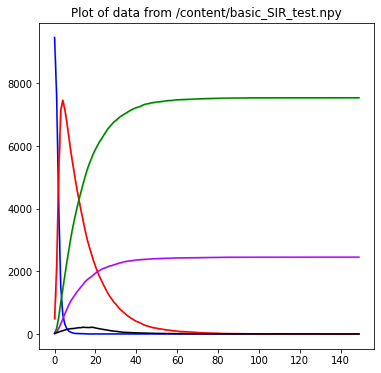

In [5]:
#@title # Körning av simuleringen{ form-width: "500px", display-mode: "form" }
#@markdown Kör först det ovanstående kodblocket för att initialisera alla funktioner.

# order of the parameters in the list sent to run_sir():
# [number_of_agents, initially_infected, test_capacity, false_tests_prob,
#  infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
#  lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
#  new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
#  new_loss_of_immunity_prob, neural_network_activated, number_of_societies, travelrate, divided_start, free_evolution, number of hotspots]

# 
standard_values = [10000,30,30,0,0.7,0.02,0.01,0,0,0,25,0,0,0,0,0,0,0, True, 1, 0, False, False, 0]



#@markdown Standard simulering?
standard_simulation = True #@param {type:"boolean"}

#@markdown Vilken bekämpningsstrategi vill du implementera? 
containment_strategy = "PETER" #@param ["None (Free Evolution)", "PETER", "Contact Tracing"]

if containment_strategy == "None (Free Evolution)":
    free_evolution = True
    neural_network_activated = False
elif containment_strategy == "PETER":
    free_evolution = False
    neural_network_activated = True
else: 
    free_evolution = False
    neural_network_activated = False


#@markdown Samhällesinställningar
number_of_agents = 5000 #@param {type:"slider", min:100, max:10000, step:50}
initially_infected = 30 #@param {type:"slider", min:5, max:500, step:5}

#@markdown Testningsinställningar
test_capacity = 30 #@param {type:"slider", min:5, max:100, step:5}
false_tests_prob = 0 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown Sjukdomsinställningar
infection_rate = 0.7 #@param {type:"slider", min:0, max:1, step:0.01}
recovery_rate = 0.02 #@param {type:"slider", min:0, max:1, step:0.01}
death_rate = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
loss_of_immunity_prob = 0 #@param {type:"slider", min:0, max:1, step:0.01}

#@markdown Nedstängningsinställningar
lockdown_activated = False #@param {type:"boolean"}
lockdown_start_time = 125 #@param {type:"slider", min:25, max:250, step:25}
lockdown_duration = 50 #@param {type:"slider", min:25, max:200, step:25}
if not lockdown_activated:
    lockdown_start_time = 0

#@markdown Åldersinställningar
age_activated = False #@param {type:"boolean"}
proportion_of_old_people = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
death_rate_old_people = 0.04 #@param {type:"slider", min:0, max:1, step:0.01}
if not age_activated:
    proportion_of_old_people = 0
    death_rate_old_people = death_rate

#@markdown Mutationsinställningar
mutation_activated = False #@param {type:"boolean"}
mutation_start_time = 10 #@param {type:"slider", min:0, max:250, step:10}
new_infection_rate = 0.6 #@param {type:"slider", min:0, max:1, step:0.01}
new_recovery_rate = 0.01 #@param {type:"slider", min:0, max:1, step:0.01}
new_death_rate = 0.05 #@param {type:"slider", min:0, max:1, step:0.01}
new_death_rate_old_people = 0.1 #@param {type:"slider", min:0, max:1, step:0.01}
new_loss_of_immunity_prob = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
if not mutation_activated:
    mutation_start_time = 0 
    new_infection_rate = 0 
    new_recovery_rate = 0 
    new_death_rate = 0 
    new_loss_of_immunity_prob = 0 
if (not age_activated) or (not mutation_activated):
    new_death_rate_old_people = death_rate 
    

#@markdown Flera samhällen?
number_of_societies = 1 #@param ["1", "2", "4"] {type:"raw"}
number_of_societies = int(number_of_societies)
travelrate = 0.2 #@param {type:"slider", min:0, max:1, step:0.01}
travelrate = int(number_of_agents*travelrate)
divided_start = True #@param {type:"boolean"}

#@markdown Befolkningsklusterinställningar
hotspots_activated = False #@param {type:"boolean"}
number_of_hotspots = 8 #@param {type:"slider", min:0, max:20, step:1}

if not hotspots_activated:
    number_of_hotspots = 0

if standard_simulation:
    running_values = standard_values
else:
    running_values = [number_of_agents, initially_infected, test_capacity, false_tests_prob,
    infection_rate, recovery_rate, death_rate, death_rate_old_people, loss_of_immunity_prob,
    lockdown_start_time, lockdown_duration,proportion_of_old_people, mutation_start_time,
    new_infection_rate, new_recovery_rate, new_death_rate, new_death_rate_old_people,
    new_loss_of_immunity_prob, neural_network_activated, number_of_societies, travelrate, divided_start,
    free_evolution, number_of_hotspots]


#@markdown --------------------------------
#@markdown Medelvärdesinställningar 

folder_path = "/content/"
#@markdown Vad ska filernas namn vara?
simulation_name = "basic_SIR_test" #@param {type:"string"}
#@markdown Hur många körningar vill du medelvärdesbilda över? 
sample_size = 1 #@param {type:"slider", min:1, max:50, step:1}


create_averages(running_values, folder_path, simulation_name, sample_size)